<a href="https://colab.research.google.com/github/jewoolee0502/ComputerVision/blob/main/ECSE415_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE 415: Introduction to Computer Vision
Jewoo Lee - 260910789

## Assignment 3: Classifiers and Object Recognition

### Library Requirements

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# install ultralytics for YOLO
!pip install -q ultralytics

# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import math
import torch

from ultralytics import YOLO
from PIL import Image
from skimage.feature import hog
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### Path

In [2]:
path = '/content/drive/MyDrive/McGill/2025/Fall 2025/ECSE 415/A3/'

### 1. Face Detection

#### 1.1 Load all images from Q1 and convert them to grayscale

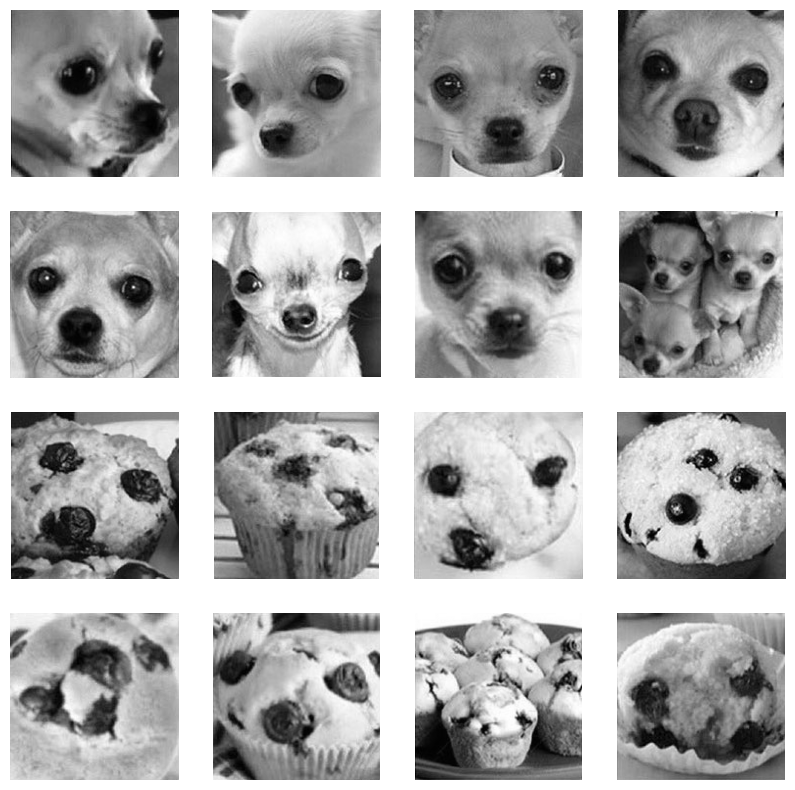

In [3]:
# getting image paths
q1_path = path + 'Q1/'
extensions = ['*.jpg', '*.jpeg']
image_paths = []

for ext in extensions:
  image_paths.extend(glob.glob(os.path.join(q1_path, ext)))

images = []

# loading all images in Q1
for image_path in image_paths:
  image = cv2.imread(image_path)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  images.append(gray_image)

# total 16 images in Q1
rows = 4
cols = 4

# display grayscale images in a grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
for i in range(rows):
  for j in range(cols):
    axs[i, j].imshow(images[i * cols + j], cmap='gray')
    axs[i, j].axis('off')

    # print each image size
    # print(images[i * cols + j].shape)

plt.show()

#### 1.2 Compute and display the mean face of the Chihuahua images

[[ 96  95  97 ... 128 127 128]
 [ 97 101 104 ... 130 127 124]
 [101 106 106 ... 133 129 126]
 ...
 [150 154 153 ... 170 167 164]
 [151 155 154 ... 168 165 165]
 [152 155 155 ... 165 166 169]]


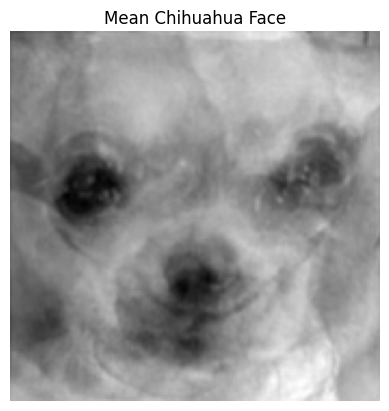

In [15]:
# loading all Chihuahua images
chihuahua_images = []

for image_path in image_paths:
  if 'chihuahua' in image_path:
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    chihuahua_images.append(gray_image)

# resize all chihuahua images
resized_chihuahua_images = []
target_size = (chihuahua_images[0].shape[1], chihuahua_images[0].shape[0])

for img in chihuahua_images:
  if img.shape != chihuahua_images[0].shape:
    img = cv2.resize(img, (target_size))

  resized_chihuahua_images.append(img)

# compute mean face
chihuahua_stack = np.stack(resized_chihuahua_images, axis=0)
mean_img = np.mean(chihuahua_stack, axis=0).astype(np.float64)
mean_img_clipped = np.clip(mean_img, 0, 255).astype(np.uint8)
print(mean_img_clipped)

# display mean face
plt.imshow(mean_img, cmap='gray')
plt.title('Mean Chihuahua Face')
plt.axis('off')
plt.show()

#### 1.3 Implement PCA

In [17]:
# flatten chihuahua images
num_img, height, width = chihuahua_stack.shape
flattened_chihuahua_images = chihuahua_stack.reshape(num_img, -1)
print('Flattened images shape: ', flattened_chihuahua_images.shape)

# compute mean vector
mean_vector = mean_img.flatten()
print('Mean vector shape: ', mean_vector.shape)

# compute center
centered_images = flattened_chihuahua_images - mean_vector
print('Centered images shape: ', centered_images.shape)

# compute covariance matrix
cov_matrix = np.dot(centered_images, centered_images.T) / (num_img - 1)
print('covariance matrix shape: ', cov_matrix.shape)

# eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
print('eigenvalues shape: ', eigenvalues.shape)
print('eigenvectors shape: ', eigenvectors.shape)

# sort eigenvalues and eigenvectors (descending order)
indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[indices]
sorted_eigenvectors = eigenvectors[:, indices]

print('sorted eigenvalues: ', sorted_eigenvalues)
print('sorted eigenvectors: ', sorted_eigenvectors)

# compute eigenfaces
eigenfaces = np.dot(centered_images.T, sorted_eigenvectors)
normalized_eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

Flattened images shape:  (8, 29241)
Mean vector shape:  (29241,)
Centered images shape:  (8, 29241)
covariance matrix shape:  (8, 8)
eigenvalues shape:  (8,)
eigenvectors shape:  (8, 8)
sorted eigenvalues:  [ 2.8501e+07  1.9771e+07  1.2814e+07  1.0507e+07  9.4664e+06  5.8252e+06  4.8126e+06  2.7045e-09]
sorted eigenvectors:  [[   -0.34965     0.71058    0.079178   -0.022899    -0.21432     0.17761     -0.4044    -0.35355]
 [    0.28422   -0.098777     0.63659     0.43847    0.085763     0.40575     0.12236    -0.35355]
 [   -0.15637     0.16636     0.14774    -0.37781    -0.13721    -0.18701      0.7775    -0.35355]
 [   -0.12494    -0.42189    -0.32715    -0.39455   -0.018477     0.64257    -0.07389    -0.35355]
 [   0.091762    -0.22134     0.36069    -0.44317     0.31965    -0.45085    -0.43087    -0.35355]
 [    0.76883     0.27182    -0.44938    0.013216   -0.016433   -0.087305   0.0036008    -0.35355]
 [   -0.14431    -0.39579     -0.1068     0.35623    -0.65172    -0.34958    -0

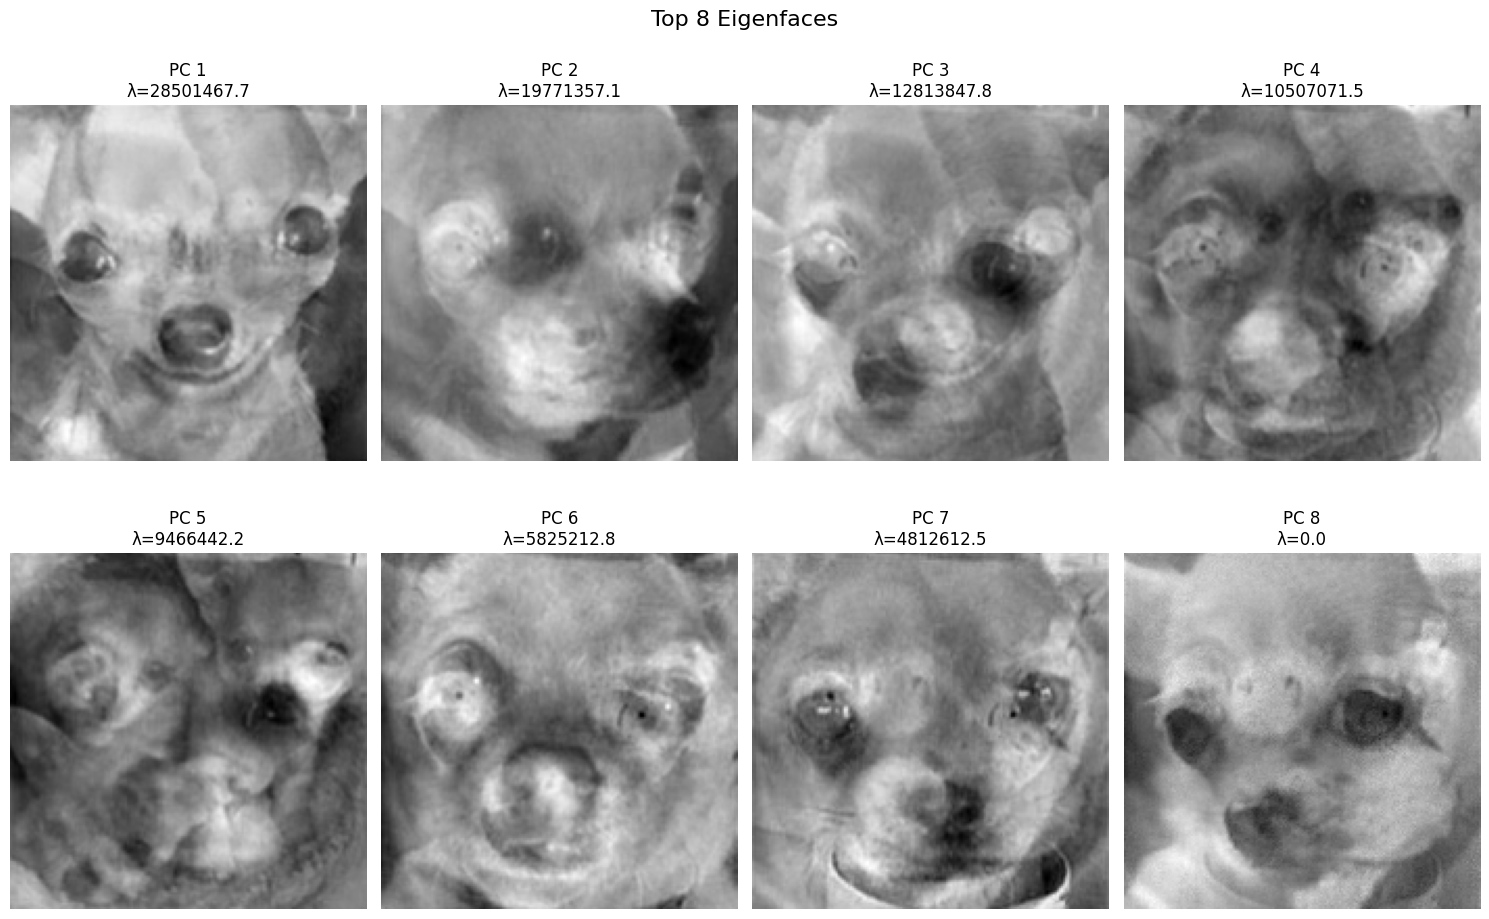

In [18]:
# display top 8 eigenfaces
num_eigenfaces = 8
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
fig.suptitle('Top 8 Eigenfaces', fontsize=16)

for i in range(num_eigenfaces):
  eigenface = eigenfaces[:, i].reshape(height, width)

  # normalize
  eigenface_display = (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface))
  eigenface_display = (eigenface_display * 255).astype(np.uint8)

  axs[i // 4, i % 4].imshow(eigenface, cmap='gray')
  axs[i // 4, i % 4].set_title(f'PC {i+1}\nλ={sorted_eigenvalues[i]:.1f}')
  axs[i // 4, i % 4].axis('off')

plt.tight_layout()
plt.show()

Projected images shape:  (8, 6)


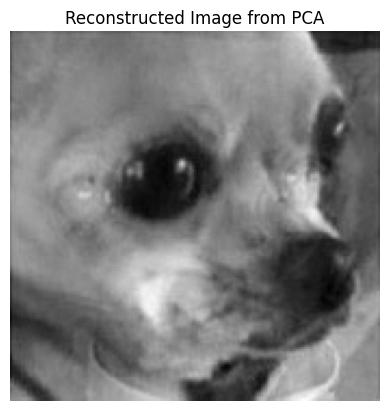

In [19]:
# projecting images onto top k eigenvectors
k = 6
W = normalized_eigenfaces[:, :k]
projected_images = np.dot(centered_images, W)
print('Projected images shape: ', projected_images.shape)

# reconstructing images from PCA
reconstructed_images = np.dot(projected_images[0], W.T) + mean_vector
reconstructed_images = reconstructed_images.reshape(height, width)

# display reconstructed image from PCA
plt.imshow(reconstructed_images, cmap='gray')
plt.title('Reconstructed Image from PCA')
plt.axis('off')
plt.show()

#### 1.4 Determine the number of Principal components required to explain 90% and 95%

Total variance: 91698011.5
Number of components required to explain 90% variance: 6
Number of components required to explain 95% variance: 7


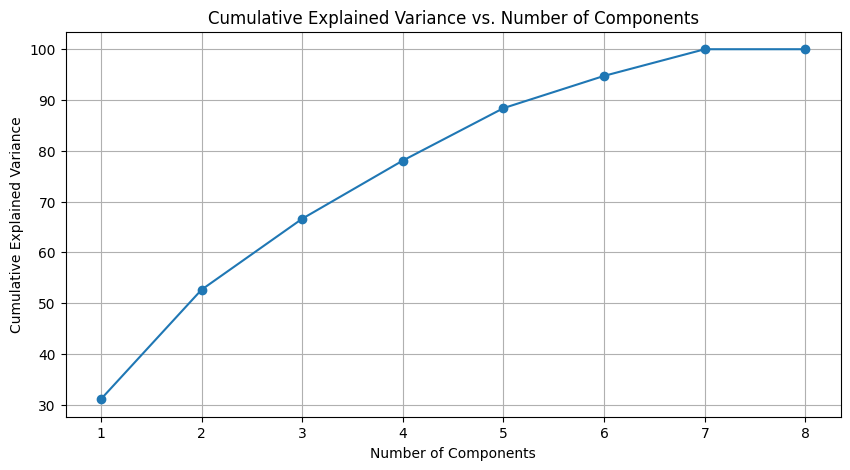

In [22]:
sorted_eigenvalues = np.array(sorted_eigenvalues, dtype=np.float64)
sorted_eigenvalues[sorted_eigenvalues < 0] = 0.0

total_variance = np.sum(sorted_eigenvalues)
variance_explained = sorted_eigenvalues / total_variance
cumulative_variance = np.cumsum(variance_explained)

print(f"Total variance: {total_variance}")

# number of 90% and 95% components variance
num_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components required to explain 90% variance: {num_components_90}")
print(f"Number of components required to explain 95% variance: {num_components_95}")

# display cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance*100, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [23]:
# reconstruction errors implementation
def reconstruction_error(flattened_chihuahua_images, centered_img, norm_eigenfaces, mean_vector, num):
  weight = norm_eigenfaces[:, :num]
  coef = np.dot(centered_img, weight)
  reconst = np.dot(coef, weight.T) + mean_vector

  mse_image = np.mean((flattened_chihuahua_images - reconst)**2, axis=1)
  mse_total = np.mean(mse_image)

  return reconst, mse_image, mse_total

# reconstruction errors for 90%
reconst_imgs_90, mse_image_90, mse_total_90 = reconstruction_error(flattened_chihuahua_images, centered_images, normalized_eigenfaces, mean_vector, num_components_90)
print(f"Average reconstruction error for 90% variance: {mse_total_90}")

# reconstruction errors for 95%
reconst_imgs_95, mse_image_95, mse_total_95 = reconstruction_error(flattened_chihuahua_images, centered_images, normalized_eigenfaces, mean_vector, num_components_95)
print(f"Average reconstruction error for 95% variance: {mse_total_95}")

Average reconstruction error for 90% variance: 144.011351218421
Average reconstruction error for 95% variance: 4.32799650476664e-26


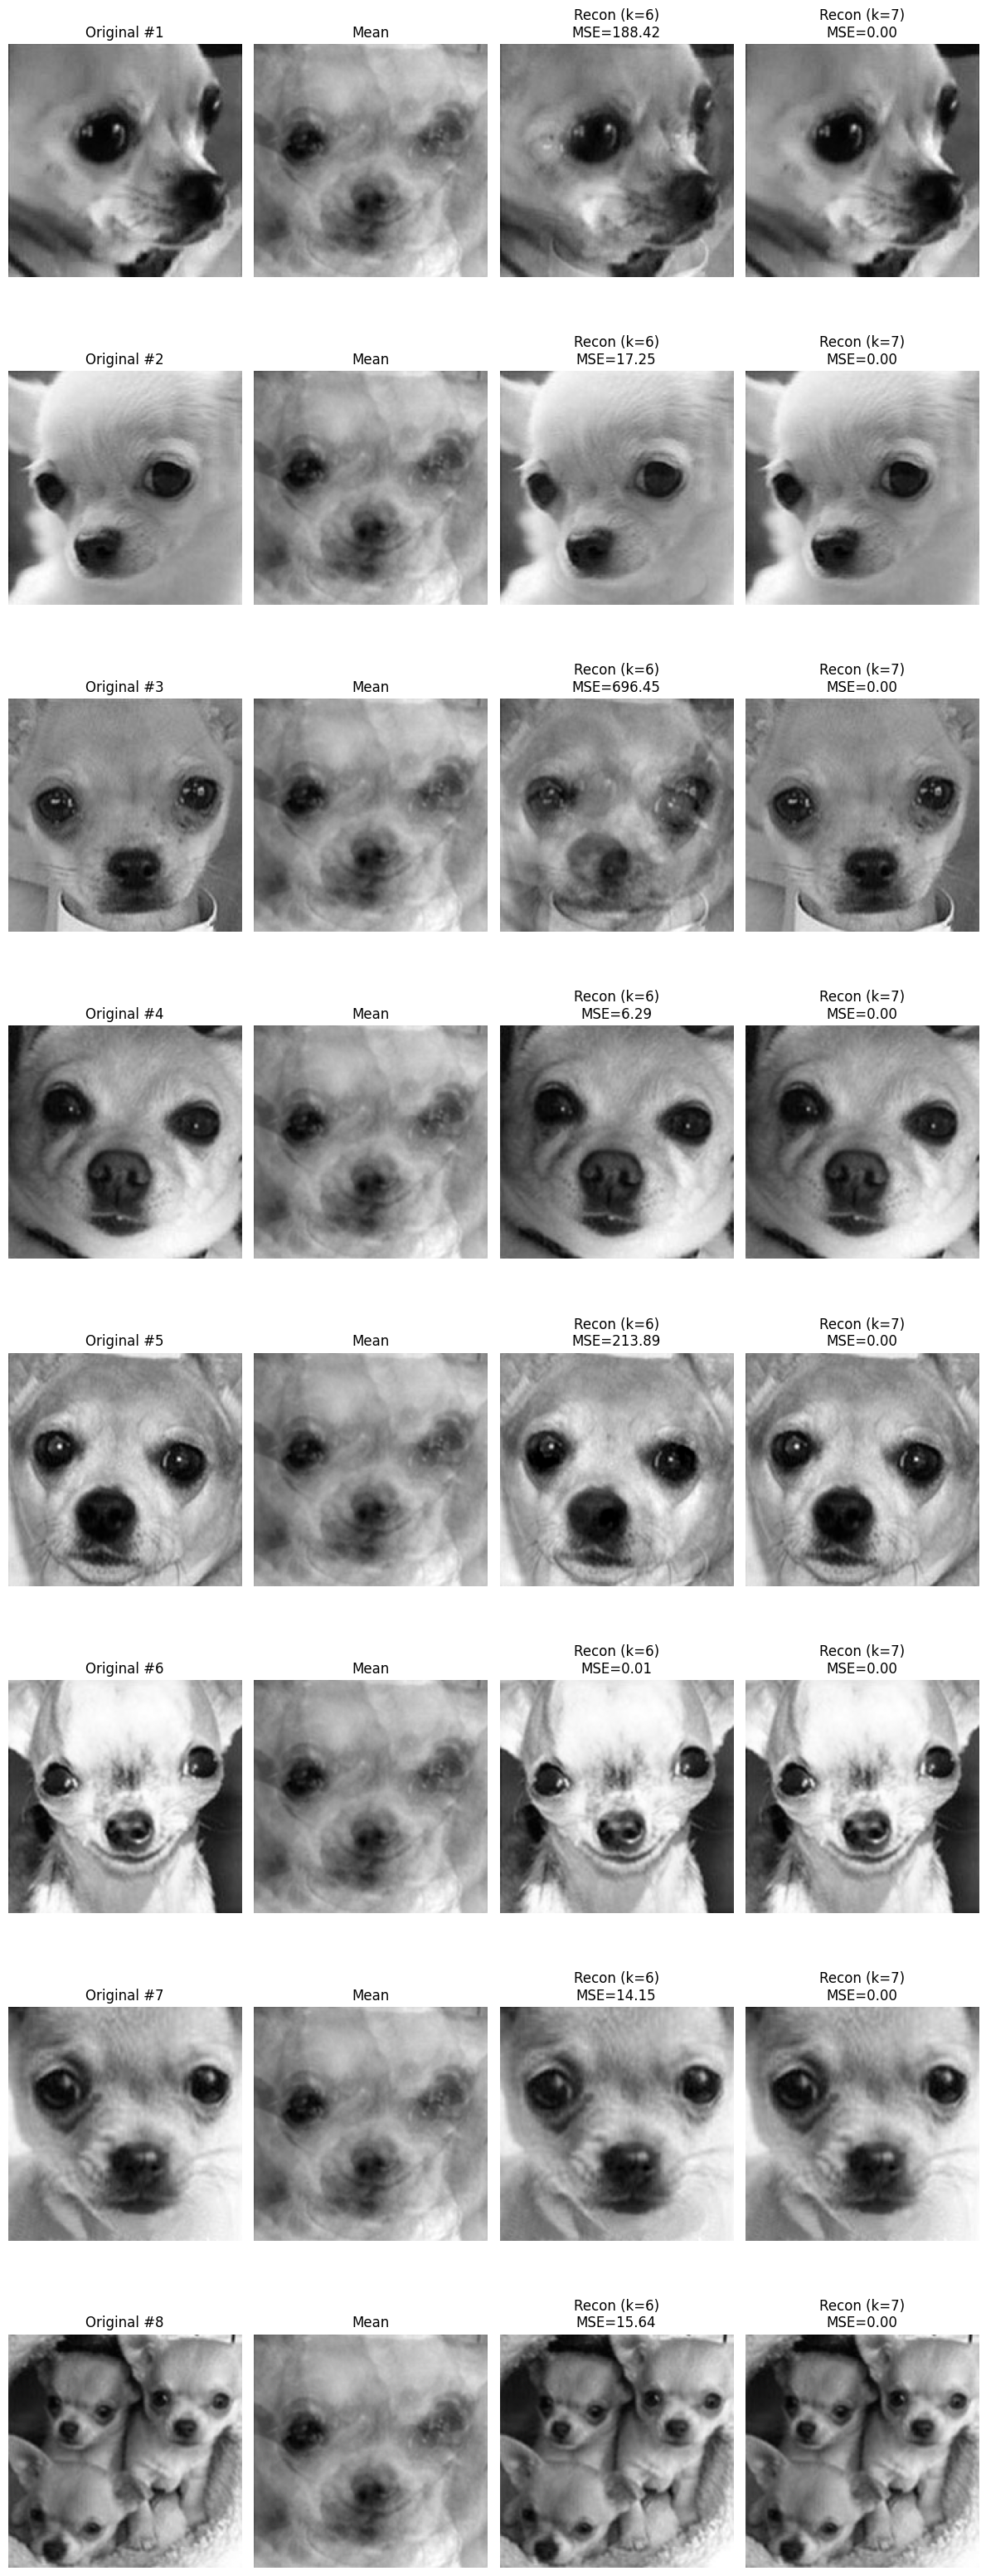

In [24]:
# display
def plot_original_mean_reconstruction(n_90, n_95, flattened_img, mean_vec, W, h, w):
  # reconstruction errors for 90% and 95%
  reconst_90, mse_90, mse_total_90 = reconstruction_error(flattened_img, centered_images, W, mean_vec, n_90)
  reconst_95, mse_95, mse_total_95 = reconstruction_error(flattened_img, centered_images, W, mean_vec, n_95)

  plt.figure(figsize=(12, 4*num_img))
  for i in range(num_img):
    original_img = flattened_img[i].reshape(h, w)
    mean_img = mean_vec.reshape(h, w)
    reconst_90_img = reconst_90[i].reshape(h, w)
    reconst_95_img = reconst_95[i].reshape(h, w)

    # Original
    plt.subplot(num_img, 4, 4*i + 1)
    plt.imshow(np.clip(original_img, 0, 255).astype(np.uint8), cmap='gray')
    plt.title(f'Original #{i+1}')
    plt.axis('off')

    # Mean
    plt.subplot(num_img, 4, 4*i + 2)
    plt.imshow(np.clip(mean_img, 0, 255).astype(np.uint8), cmap='gray')
    plt.title('Mean')
    plt.axis('off')

    # Reconstruction 90%
    plt.subplot(num_img, 4, 4*i + 3)
    plt.imshow(np.clip(reconst_90_img, 0, 255).astype(np.uint8), cmap='gray')
    plt.title(f'Recon (k={n_90})\nMSE={mse_90[i]:.2f}')
    plt.axis('off')

    # Reconstruction 95%
    plt.subplot(num_img, 4, 4*i + 4)
    plt.imshow(np.clip(reconst_95_img, 0, 255).astype(np.uint8), cmap='gray')
    plt.title(f'Recon (k={n_95})\nMSE={mse_95[i]:.2f}')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

plot_original_mean_reconstruction(num_components_90, num_components_95,
                                  flattened_chihuahua_images, mean_vector, normalized_eigenfaces, height, width)

##### Discussion:

Discuss the results

#### 1.5 Project muffin images onto eigenface subspace

In [10]:
k = num_components_90

# loading all muffin images
muffin_images = []
muffin_paths = []

for image_path in image_paths:
  if 'muffin' in image_path:
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    muffin_images.append(gray_image)
    muffin_paths.append(image_path)

# resize all muffin images
resized_muffin_images = []

for img in muffin_images:
  if img.shape != muffin_images[0].shape:
    img = cv2.resize(img, (muffin_images[0].shape[1], muffin_images[0].shape[0]))

  resized_muffin_images.append(img)

print('Resized muffin images to: ', resized_muffin_images[0].shape)

# flatten muffin images
flattened_muffin_images = np.array([img.flatten() for img in resized_muffin_images])
print('Flattened muffin images shape: ', flattened_muffin_images.shape)

# center muffin images
centered_muffin_images = flattened_muffin_images - mean_vector # using mean vector from chihuahua
print('Centered muffin images shape: ', centered_muffin_images.shape)

# muffin images onto top k eigenfaces
muffin_coef = centered_muffin_images @ eigenfaces[:, :k]
print('Muffin images onto top k eigenfaces shape: ', muffin_coef.shape)

Resized muffin images to:  (171, 171)
Flattened muffin images shape:  (8, 29241)
Centered muffin images shape:  (8, 29241)
Muffin images onto top k eigenfaces shape:  (8, 6)


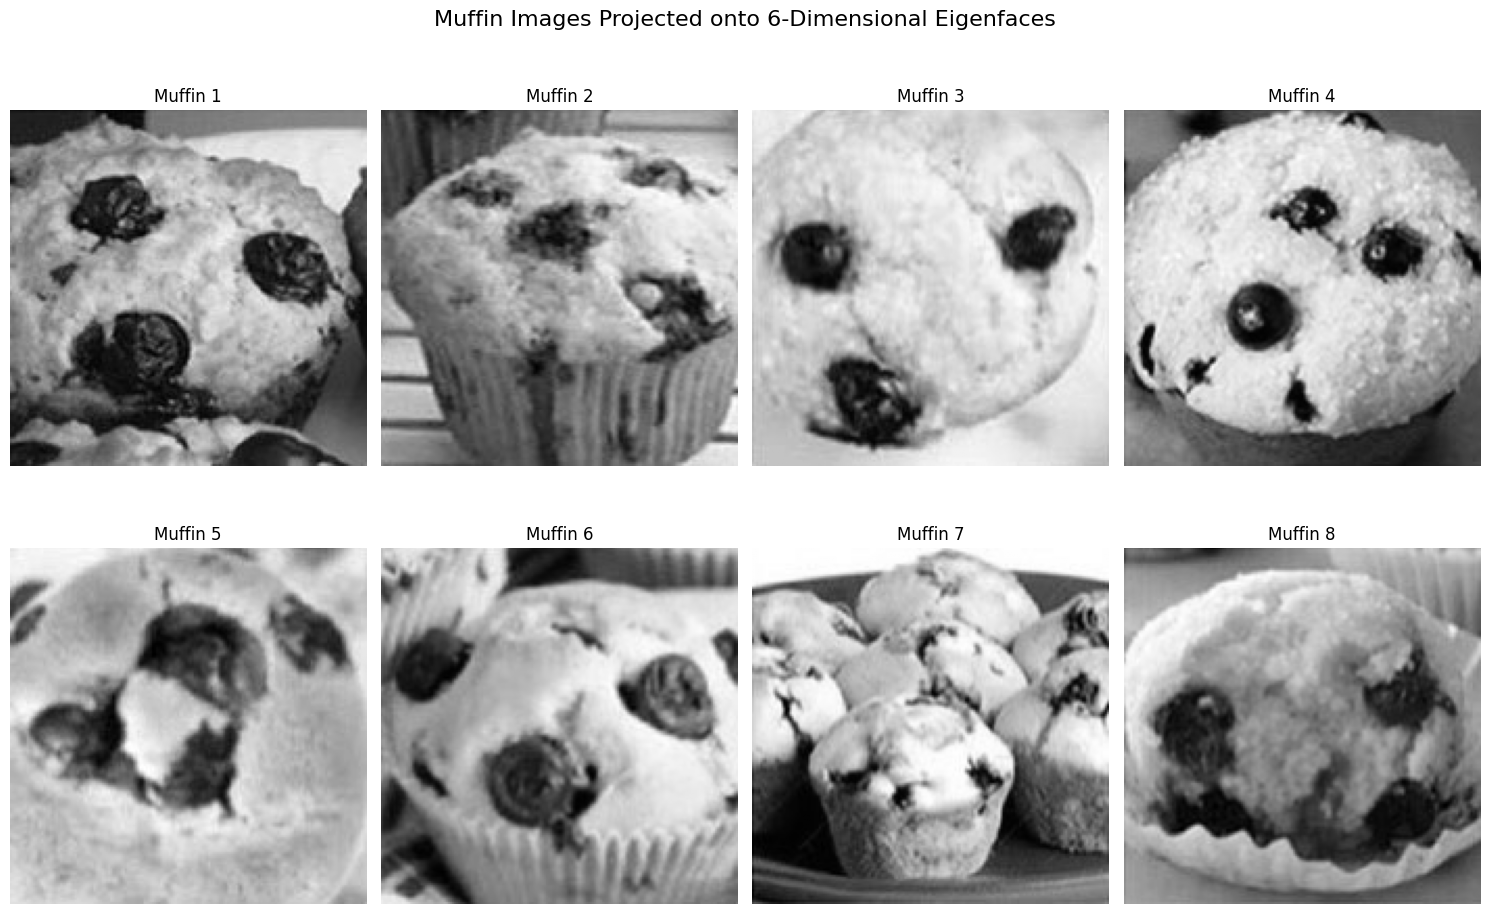

In [11]:
# display
num = len(resized_muffin_images)

fig, axs = plt.subplots(2, 4, figsize=(15, 10))
fig.suptitle(f"Muffin Images Projected onto {k}-Dimensional Eigenfaces", fontsize=16)

for i in range(num):
  axs[i // 4, i % 4].imshow(resized_muffin_images[i], cmap='gray')
  axs[i // 4, i % 4].set_title(f'Muffin {i+1}')
  axs[i // 4, i % 4].axis('off')

plt.tight_layout()
plt.show()

#### 1.6 Compute Euclidean distances (Sort Ascending Order)

In [12]:
# compute Euclidean distance for each muffin
distances = []
for i in range(len(muffin_coef)):
    dist = np.linalg.norm(muffin_coef[i])
    distances.append(dist)

# results DataFrame
results_df = pd.DataFrame({
    'Image': [os.path.basename(path) for path in muffin_paths],
    'Path': muffin_paths,
    'Distance': distances
})

# sort by distance in ascending order
sorted_results_df = results_df.sort_values('Distance', ascending=True).reset_index(drop=True)

print("Distances Sorted in Ascending Order: \n")
print(sorted_results_df[['Image', 'Distance']])

# statistics summary
print(f"\nStatistics:\n")
print(f"Minimum distance: {sorted_results_df['Distance'].min():.2f}")
print(f"Maximum distance: {sorted_results_df['Distance'].max():.2f}")
print(f"Mean distance: {sorted_results_df['Distance'].mean():.2f}")
print(f"Median distance: {sorted_results_df['Distance'].median():.2f}")
print(f"Standard deviation: {sorted_results_df['Distance'].std():.2f}")

Distances Sorted in Ascending Order: 

           Image     Distance
0  muffin-2.jpeg  2385.544020
1  muffin-1.jpeg  3095.214002
2  muffin-5.jpeg  3380.240224
3  muffin-6.jpeg  4062.474191
4  muffin-4.jpeg  4095.571591
5  muffin-8.jpeg  4368.751482
6  muffin-7.jpeg  4985.681266
7  muffin-3.jpeg  6363.948385

Statistics:

Minimum distance: 2385.54
Maximum distance: 6363.95
Mean distance: 4092.18
Median distance: 4079.02
Standard deviation: 1221.83


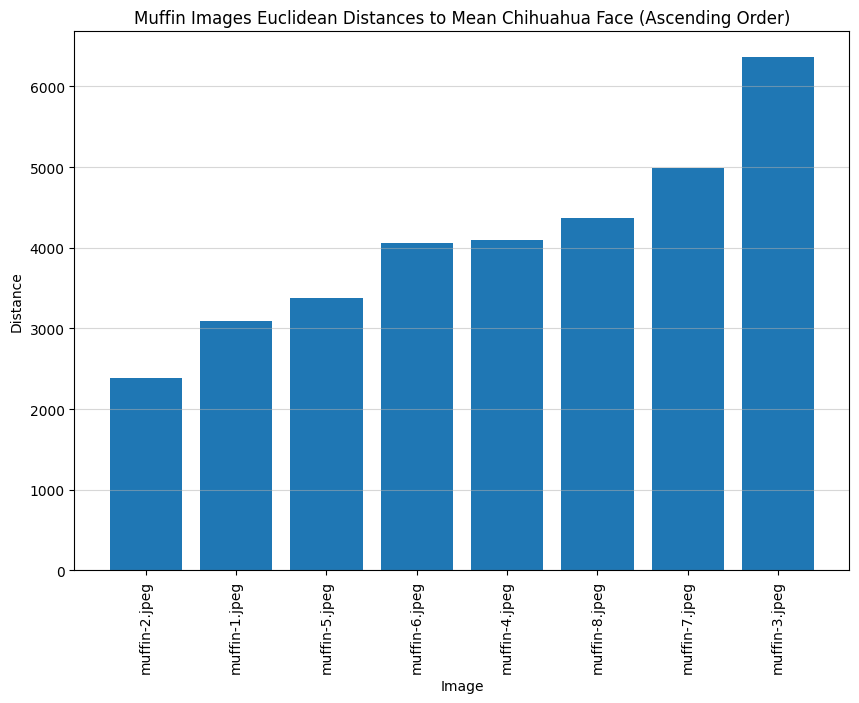

In [13]:
# bar plot
plt.figure(figsize=(10, 7))
plt.bar(sorted_results_df['Image'], sorted_results_df['Distance'])
plt.xlabel('Image')
plt.ylabel('Distance')
plt.title('Muffin Images Euclidean Distances to Mean Chihuahua Face (Ascending Order)')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.5)
plt.show()

#### 1.7 Use YOLOv5 weights to detect Chihuahuas

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



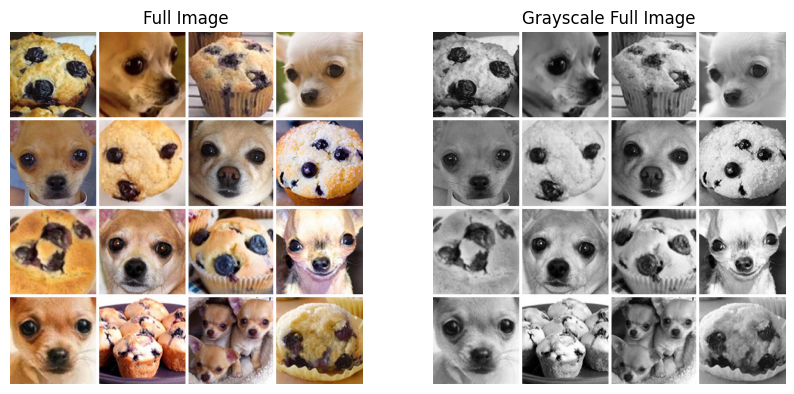


0: 640x640 8 dogs, 1 bear, 3 teddy bears, 1478.1ms
Speed: 33.2ms preprocess, 1478.1ms inference, 55.6ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 

In [14]:
# YOLOv5 models
model = YOLO('yolov5s.pt')

# image path
full_img_path = path + 'full.jpg'
full_img = cv2.imread(full_img_path)

# color full image and grayscale full image
full_img_rgb = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
full_img_gray = cv2.cvtColor(full_img, cv2.COLOR_BGR2GRAY)

# display
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(full_img_rgb)
plt.title('Full Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(full_img_gray, cmap='gray')
plt.title('Grayscale Full Image')
plt.axis('off')

plt.show()

# predict with the model
# confident = 0.5 and intersection-over-union=0.7 (boxes overlap > 0.7 -> treat as the same object)
results = model(full_img_rgb, conf=0.5, iou=0.5) # https://docs.ultralytics.com/tasks/detect/#val

# display results
print(results)

### 2. Classifiers

#### 2.1 Dataset Preparation

#### 2.2 Feature Extraction

#### 2.3 SVM Classifiers

#### 2.4 Random Forest Classifiers

#### 2.5 Testing and Visualization

#### 2.6 Analysis and Discussion